Importing libraries

In [1]:
import pybammeis
import pybamm
import os
import re
import numpy as np
from gamry_parser import GamryParser, Impedance
import pandas as pd
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft
import random
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.interpolate import interp1d
import pyswarms as ps 
from pyswarms.single import GlobalBestPSO

Uploading experimental data

In [2]:
# ved ca. 45% SoC 
# ved 25 deg C

def get_exp_data(i, d): 
    z_list = []
    file = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_01_EIS-SoC_01-05/MJ1_01_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"
    ca = Impedance(file)
    ca.load(filename=file)

    # extract EIS curve
    res = ca.get_curve_data().iloc[::-1]
    #print(res)
    df_real = res['Zreal']
    df_imag= res['Zimag']
    df_freq = res['Freq']
    #df_name = res['Vdc']

    # Removing the points beneath the y-axis 
    real = df_real[df_imag <= 0]
    imag = df_imag[df_imag <= 0]
    freq = df_freq[df_imag <= 0]
    
    #name = sum(df_name)/len(df_name)
    # Adding the impendances to the list 
    z_list.append(real)
    z_list.append(imag)
    return[z_list, freq] #, df_name]

get_exp_data(1, "d")[0]

#get_exp_data(1, "d")[2]




[Pt
 70    0.039511
 69    0.038682
 68    0.038006
 67    0.037462
 66    0.037024
 65    0.036640
 64    0.036303
 63    0.035978
 62    0.035709
 61    0.035504
 60    0.035207
 59    0.034920
 58    0.034674
 57    0.034471
 56    0.034276
 55    0.034117
 54    0.033972
 53    0.033844
 52    0.033742
 51    0.033653
 50    0.033555
 49    0.033471
 48    0.033377
 47    0.033290
 46    0.033209
 45    0.033298
 44    0.033255
 43    0.033208
 42    0.033161
 41    0.033111
 40    0.033061
 39    0.032989
 38    0.032905
 37    0.032815
 36    0.032679
 35    0.032522
 34    0.032351
 33    0.032097
 32    0.031842
 31    0.031568
 30    0.031237
 29    0.030907
 28    0.030546
 27    0.030177
 26    0.029769
 25    0.029379
 24    0.028962
 Name: Zreal, dtype: float64,
 Pt
 70   -0.007952
 69   -0.006879
 68   -0.005963
 67   -0.005154
 66   -0.004489
 65   -0.003931
 64   -0.003481
 63   -0.003084
 62   -0.002768
 61   -0.002483
 60   -0.002237
 59   -0.002027
 58   -0.001831
 5

Plotting

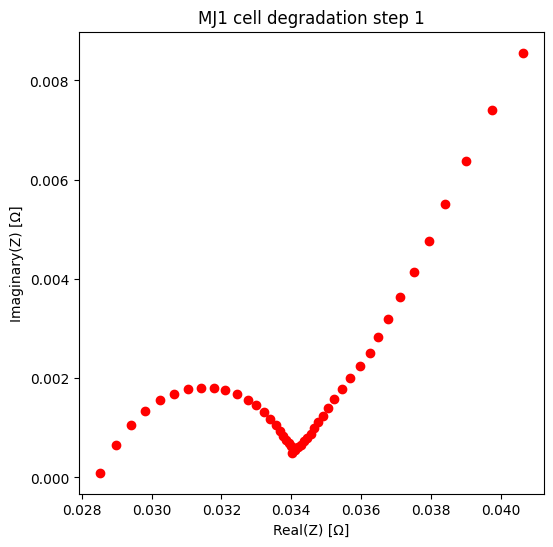

In [3]:
def plotting(i, d): 
    # Creating Nyquist plot
    plt.figure(figsize=(6,6))
    plt.scatter(get_exp_data(i, d)[0][0], -get_exp_data(i, d)[0][1], color='red') 

    # Labeling the plot
    plt.xlabel('Real(Z) [Ω]')
    plt.ylabel('Imaginary(Z) [Ω]')
    plt.title('MJ1 cell degradation step '+str(i))
    plt.show()

plotting(1, "")

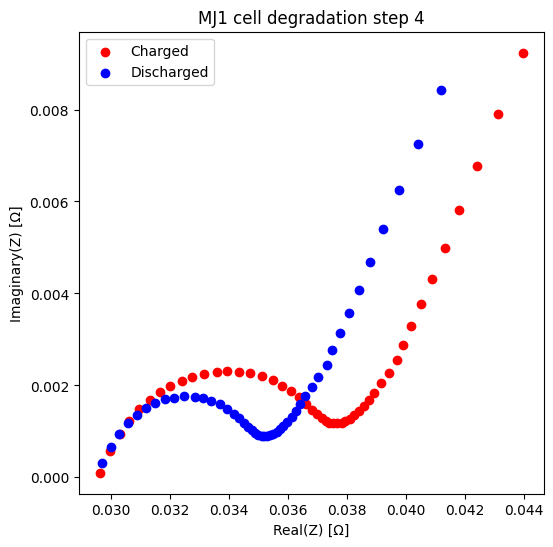

In [4]:
def combined_plot(i):
    # Creating the figure for both the charged and discharged data
    plt.figure(figsize=(6, 6))

    z_list_charged = get_exp_data(i, "")[0]
    z_list_discharged = get_exp_data(i, "d")[0]

    # Plot 
    plt.scatter(z_list_charged[0], -z_list_charged[1], color='red', label='Charged')
    plt.scatter(z_list_discharged[0], -z_list_discharged[1], color='blue', label='Discharged')

    # Adding labels and title
    plt.xlabel('Real(Z) [Ω]')
    plt.ylabel('Imaginary(Z) [Ω]')
    plt.title(f'MJ1 cell degradation step {i}')
    plt.legend()
    plt.show()

combined_plot(4)


Optimization of ECM parameters

In [5]:
# Randles components parameters 
c_elem = {
    "R_el": 0.026455095283510706,  # Electrolyte resistance (Ohms)
    "L": 5.534820787666664e-07, # Inductance (H)
    
    #Cathode? 
    "R_ct1": 0.0055426231465975665,  # Charge transfer resistance (Ohms)
    "Q1" : 0.6755099612832921, 
    "alpha1": 0.6624587164477784, 
    "A1": 0.0010503007445281985,     # Warburg coefficient
    "a_w1": 0.5722885441839765, 

    #Anode? 
    "R_ct2": 0.005384825939881047,  # Charge transfer resistance (Ohms)
    "Q2" : 2.339974970415867, 
    "alpha2": 0.8629910852751331, 
    "A2": 0.0011934570596558787,     # Warburg coefficient
    "a_w2": 0.5860161540205311, 
    }


# Function to convert dictionary to list
def dict_to_list(c_elem):
    return list(c_elem.values())

# Function to convert list back to dictionary
def list_to_dict(c_elem, optimized_values):
    keys = list(c_elem.keys())
    return dict(zip(keys, optimized_values))


In [16]:
exp_real = np.array(get_exp_data(5, "")[0][0])
exp_imag = np.array(get_exp_data(5, "")[0][1])
frequencies = np.array(get_exp_data(5, "")[1])


# Angular frequencies
ang_freq = 2*np.pi*frequencies

# Define Warburg impedance
def wni_imp(omega, A, a_w): # Non-Ideal 
    return A /(1j * omega)** a_w

# CPE for non-ideal capicitance behaviour
def cpe_imp(omega, Q, alpha): 
    return 1/(Q*(1j*omega)**alpha)

# Define Inductance impedance
def i_imp(omega, L): 
    return 1j*omega*L


def calc_Z(comp): 
    # Update c_elem dictionary from the flat parameter list (comp)
    c_elem_up = list_to_dict(c_elem, comp)

    Z_W1 = wni_imp(ang_freq, c_elem_up["A1"], c_elem_up["a_w1"])
    Z_cdl1 = cpe_imp(ang_freq, c_elem_up["Q1"], c_elem_up["alpha1"])
    Z_L = i_imp(ang_freq, c_elem_up["L"])

    Z_W2 = wni_imp(ang_freq, c_elem_up["A2"], c_elem_up["a_w2"])
    Z_cdl2 = cpe_imp(ang_freq, c_elem_up["Q2"], c_elem_up["alpha2"])

    Z1 =  1/(1/(c_elem_up["R_ct1"] + Z_W1) + 1/Z_cdl1)
    Z2 =  1/(1/(c_elem_up["R_ct2"] + Z_W2) + 1/Z_cdl2)
    Z = Z_L + c_elem_up["R_el"] + Z1 + Z2

    Z1 =  1/(1/(c_elem_up["R_ct1"] + Z_W1) + 1/Z_cdl1)
    Z2 =  1/(1/(c_elem_up["R_ct2"]) + 1/Z_cdl2)
    Z = Z_L + c_elem_up["R_el"] + Z1 + Z2
    return Z 



# function for difference between the ECM model and the experimental values
def diff_func(comp, exp_real, exp_imag): 

    Z = calc_Z(comp)

    diff_real = Z.real - exp_real 
    diff_imag = Z.imag - exp_imag 
    sum_square_diff = np.sum(diff_real**2 + diff_imag**2)
    return sum_square_diff

# Convert initial dictionary to list for optimization
initial_elems = dict_to_list(c_elem)

options = {
    'maxiter': 10000,    # Maximum number of iterations
    'ftol': 1e-10,       # Function value tolerance
    #'disp': True         # Display convergence messages
}

# Minimize the difference function (optimize parameters)
opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)

# Convert the optimized list back to dictionary
opt_elems = list_to_dict(c_elem, opt.x)

# Print the optimized elements
print("Optimized elements:", opt_elems)

# Print the difference after optimization
print("Final sum of squared difference:", diff_func(opt.x, exp_real, exp_imag))





/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_29205/3069732312.py:64: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)


Optimized elements: {'R_el': 0.027755837670122397, 'L': 5.514054750736704e-07, 'R_ct1': 0.005750160526172637, 'Q1': 0.6800680922614128, 'alpha1': 0.6642360550475555, 'A1': 0.0025625991043038, 'a_w1': 0.5751999423700601, 'R_ct2': 0.0054835153640370865, 'Q2': 2.3336552690496837, 'alpha2': 0.8664316287724392, 'A2': 0.0011934570596558787, 'a_w2': 0.5860161540205311}
Final sum of squared difference: 3.2100672368715225e-06


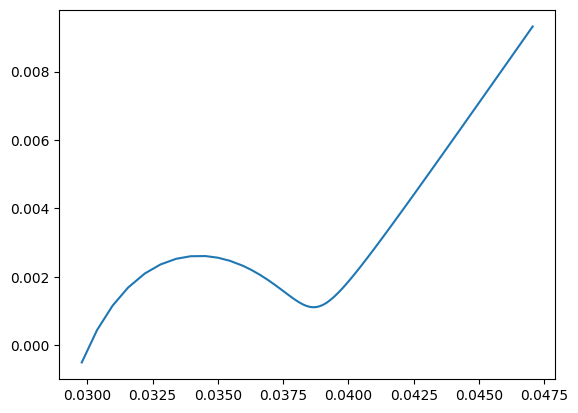

In [14]:
Z_randles = calc_Z(opt.x)

plt.plot(Z_randles.real, -Z_randles.imag)
plt.show()

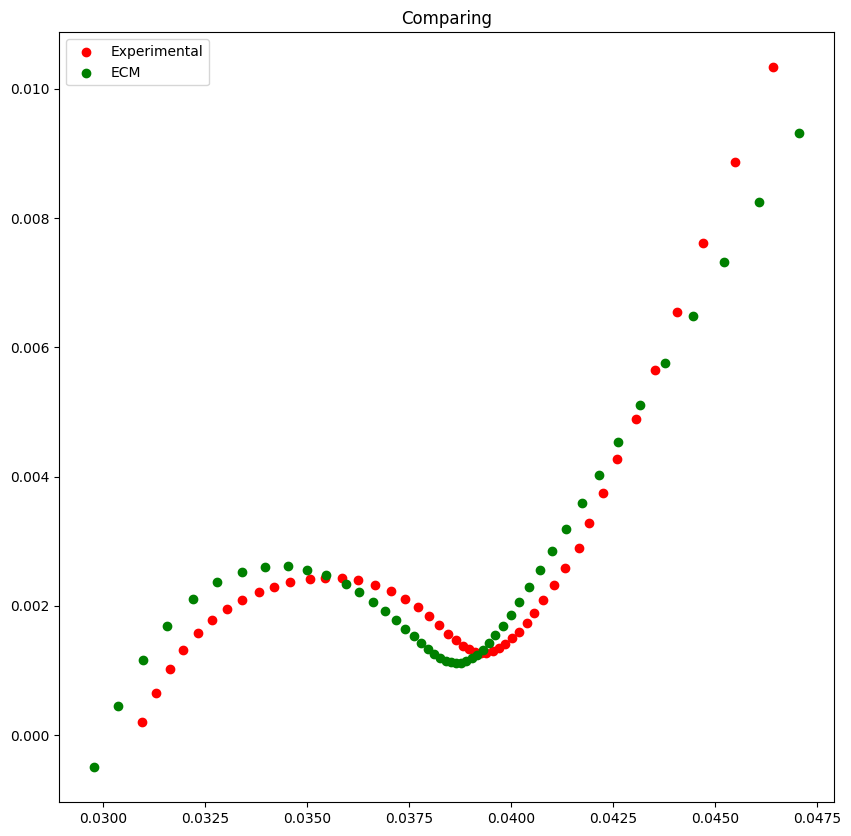

In [15]:
fig, ax = plt.subplots(figsize=(10, 10)) 
ax.scatter(exp_real, -exp_imag, label=f"Experimental", color = 'red') 
ax.scatter(Z_randles.real, -Z_randles.imag, label = f'ECM', color = 'green')

#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 